Create an ANN with Pytorch.

In [ ]:
!pip install ipykernel

In [ ]:
import warnings

warnings.filterwarnings("ignore","is_categorical_dtype")
warnings.filterwarnings("ignore","use_inf_as_na") # ignore some warnings that may appear (project sake)

In [ ]:
# to prepsocess our data
!pip install scikit-learn
# to do the nearual networs stuff
!pip install torch
# to see the metrics to evaluate our models created using pytorch
!pip install torchmetrics



In [ ]:
# all needed import statements

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# /content/drive/MyDrive/MIT IDSS/insurance_CreateANN.csv
raw_data = pd.read_csv("/content/drive/MyDrive/MIT IDSS/insurance_CreateANN.csv") # raw data are the raw data for inurance
raw_data.head()

Mounted at /content/drive


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='charges', ylabel='Count'>

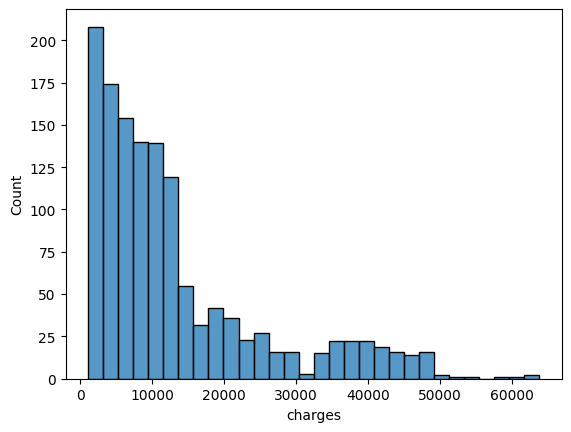

In [ ]:
sns.histplot(raw_data["charges"]) # insurance charges are lower for most customer plans

<Axes: xlabel='smoker', ylabel='charges'>

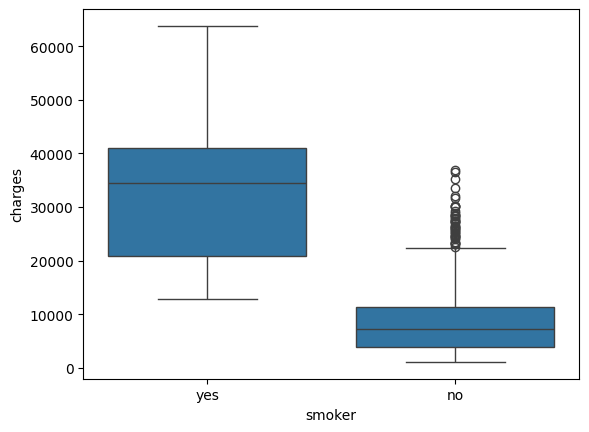

In [ ]:
sns.boxplot(y = raw_data["charges"], x = raw_data["smoker"]) # explore relations between data columns/features

In [ ]:
# lets train the data. Create training and validation sets
x = raw_data.drop(columns=["charges"])
y = raw_data["charges"] # we are predicting insurance charges

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.2, random_state = 123)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1070, 6), (268, 6), (1070,), (268,))

In [ ]:
# We want to use the features to categorize.
# transformers are NN that not only have training but retain context over a course of interactions
# we must encode data, which is say mark all types of possible values in a column/feature with an associated number/letter.
# handle_unknown --> new data digits in the columns after training will be ignored
# drop feature if all rows have the same value in the column
# sparse_output --> ?? CSR matrix related -- lookup

cat_features = ["sex", "smoker", "region"]
cat_transformer = OneHotEncoder(
    handle_unknown = "ignore", sparse_output = False, drop = "first"
)

preproc = ColumnTransformer(
    transformers = [("cat_tr", cat_transformer, cat_features)],
    remainder = "passthrough" # leave the reamining columns as they are, only affect the categorical ones in the transform
)


x_train = preproc.fit_transform(x_train)
x_val = preproc.transform(x_val)

x_train.shape, x_val.shape

((1070, 8), (268, 8))

In [ ]:
# to see the new table
pd.DataFrame(x_train, columns = preproc.get_feature_names_out()).T

,0,1,2,3,4,5,6,7,8,9,...,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069
cat_tr__sex_male,1.000,0.00,1.0,1.000,0.0,1.0,0.0,1.00,1.00,0.00,...,1.00,0.00,1.00,0.00,0.0,1.000,0.00,0.0,1.000,0.00
cat_tr__smoker_yes,0.000,1.00,0.0,0.000,0.0,0.0,0.0,0.00,1.00,0.00,...,0.00,0.00,1.00,0.00,0.0,0.000,0.00,0.0,0.000,1.00
cat_tr__region_northwest,1.000,0.00,0.0,0.000,0.0,0.0,0.0,0.00,0.00,1.00,...,0.00,1.00,0.00,1.00,0.0,0.000,1.00,0.0,0.000,1.00
cat_tr__region_southeast,0.000,1.00,0.0,0.000,0.0,1.0,0.0,1.00,1.00,0.00,...,1.00,0.00,0.00,0.00,0.0,0.000,0.00,0.0,0.000,0.00
cat_tr__region_southwest,0.000,0.00,1.0,0.000,1.0,0.0,1.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.0,0.000,0.00,1.0,0.000,0.00
remainder__age,40.000,37.00,50.0,46.000,21.0,59.0,48.0,32.00,26.00,33.00,...,58.00,28.00,39.00,21.00,54.0,37.000,20.00,19.0,18.000,53.00
remainder__bmi,26.315,38.39,26.6,24.795,17.4,26.4,28.9,37.18,27.06,42.94,...,32.01,34.77,26.41,35.72,30.8,22.705,31.92,28.4,23.085,36.86
remainder__children,1.000,0.00,0.0,3.000,1.0,0.0,0.0,2.00,0.00,3.00,...,1.00,0.00,0.00,0.00,3.0,3.000,0.00,1.0,0.000,3.00


In [ ]:
# we are convirting some data into numpy format
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

y_train[:10]

array([ 6389.37785, 40419.0191 ,  8444.474  ,  9500.57305,  2585.269  ,
       11743.299  ,  8277.523  ,  4673.3922 , 17043.3414 ,  6360.9936 ])

In [ ]:
# std deviations --> how far from the mean value
# z-score --> related to this ?? --> how many std devs from the centre?
# lets use this --> that is what std scaler does, show numbers in their z scores. say weight in row is 40kgs, how much std dev from the sample mean

stdscaler = StandardScaler()

x_train = stdscaler.fit_transform(x_train)
x_val = stdscaler.transform(x_val)

x_train

# we are preserving info, making things easy and operating in a smaller range of values.

array([[ 0.98884723, -0.5       ,  1.72132593, ...,  0.06207177,
        -0.71961   , -0.06736631],
       [-1.01127855,  2.        , -0.5809475 , ..., -0.15057538,
         1.28697921, -0.8864794 ],
       [ 0.98884723, -0.5       , -0.5809475 , ...,  0.77089561,
        -0.67224951, -0.8864794 ],
       ...,
       [-1.01127855, -0.5       , -0.5809475 , ..., -1.42645829,
        -0.37313062, -0.06736631],
       [ 0.98884723, -0.5       , -0.5809475 , ..., -1.49734067,
        -1.25636223, -0.8864794 ],
       [-1.01127855,  2.        ,  1.72132593, ...,  0.98354276,
         1.03272816,  1.57085987]])

In [ ]:
# y train before transform
y_train

array([ 6389.37785, 40419.0191 ,  8444.474  , ...,  2331.519  ,
        1704.70015, 46661.4424 ])

In [ ]:
# currently our y vals are a single array (1 array of dimensions N), to feed into a NN we need it to be in a multidimensional array
y_train.reshape(-1,1)
# this becomes multiple arrays of dimension 1

array([[ 6389.37785],
       [40419.0191 ],
       [ 8444.474  ],
       ...,
       [ 2331.519  ],
       [ 1704.70015],
       [46661.4424 ]])

In [ ]:
# scale data within a range 0 and 1 (revise the maths) --> the std dev related maths

min_max_scaler = MinMaxScaler()
y_train = min_max_scaler.fit_transform(y_train.reshape(-1, 1))

y_val = min_max_scaler.transform(y_val.reshape(-1, 1))


In [ ]:
# convert to torch tensors
# A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.
# we are grooming data to feed into the torch lib for our NN needs
import torch
train_inputs = torch.from_numpy(x_train).float()
train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()

train_inputs.shape, train_targets.shape

(torch.Size([1070, 8]), torch.Size([1070, 1]))

In [ ]:
# data is ready for processing
class SimpleNeuralNet(nn.Module): # base class for building of NN in pyTorch

  # init the NN layers
  def __init__(self, num_features):
    super().__init__()
    self.linear1 = nn.Linear(num_features, 1) # 1 layer and 1 neuron init for the no of features we have --> num_features

  def forward(self, x):
    x=self.linear1(x) # pass your input through this layer --> forward propogation
    return x

# insert the complex one instead here and rerun the functions

#######################################################

# class SimpleNeuralNet(nn.Module):

#   # init the layers
#   def __init__(self, num_features):

#     super().__init__()
#     self.layer_1 = nn.Linear(num_features, 16)
#     self.layer_2 = nn.Linear(16, 32)
#     self.layer_3 = nn.Linear(32, 16)
#     self.layer_out = nn.Linear(16, 1) # i/p o/p mapping between the layers

#     self.relu = nn.ReLU()

#   def forward(self, inputs): # forward propogation

#     x = self.relu(self.layer_1(inputs))
#     x = self.relu(self.layer_2(x))
#     x = self.relu(self.layer_3(x))

#     x = self.layer_out(x) # why not relu here? --> By now via the layers on neurons we are at a stage where we will def get an anwer as the maths is more or less done.
#                           #Only positive results from RelU so might as well not add it.

#     return (x)

#   def predict(self, test_inputs):

#     x = self.relu(self.layer_1(test_inputs))
#     x = self.relu(self.layer_2(x))
#     x = self.relu(self.layer_3(x))

#     x = self.layer_out(x)

#     return (x)


# model = SimpleNeuralNet(num_features=8)
# print(model)

SimpleNeuralNet(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
model = SimpleNeuralNet(num_features=8)

model

# so far we have created a NN

SimpleNeuralNet(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# moving onto training it.
# we have a random bias and synaptic weights initialized

for layer in model.children():

  if isinstance(layer, nn.Linear):
    print(layer.state_dict()["weight"])
    print(layer.state_dict()["bias"])

tensor([[ 0.3285,  0.1803,  0.3013,  0.2911, -0.3190,  0.1221, -0.2533,  0.0875],
        [-0.1710, -0.1720,  0.2577,  0.1112, -0.3424, -0.3222,  0.1843, -0.0512],
        [ 0.2255, -0.1997,  0.0184, -0.1555, -0.2685,  0.3488,  0.3060,  0.0931],
        [ 0.3219, -0.3290,  0.2420, -0.2510,  0.2095,  0.1705, -0.0983,  0.2346],
        [ 0.0070, -0.2879, -0.2574, -0.2328,  0.0171, -0.1789, -0.3253, -0.1397],
        [ 0.1126,  0.3126, -0.0027,  0.1047,  0.0135, -0.0057, -0.1675, -0.0257],
        [-0.0407, -0.3084, -0.0491, -0.2726,  0.2014,  0.1582, -0.2277, -0.3054],
        [-0.1084, -0.2118, -0.0559, -0.3185, -0.0864,  0.0497, -0.3416, -0.0438],
        [-0.1339,  0.0298,  0.0912, -0.1791, -0.3478, -0.1168,  0.0873, -0.2320],
        [ 0.2602,  0.3333,  0.1249, -0.2010,  0.0852, -0.3016,  0.0542, -0.0833],
        [-0.3375, -0.0651,  0.2233, -0.3003,  0.1034,  0.2742, -0.3374, -0.2771],
        [ 0.0383, -0.3154,  0.1962,  0.1492,  0.1797,  0.1162,  0.0567,  0.0204],
        [ 0.2679

In [ ]:
# we can count parameters of the model
# what are these --- ? The entitites in the NN that we can adjust to enable learning --> weights + bias (here thus 9 (8+1))
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

1233

In [ ]:
# introduce a loss function --> how to calculate error of the whole NN, aka how far are the NN predictions from the actual values

import torch.nn.functional as F

loss_fn = F.mse_loss #(mean square error)

In [ ]:
# calculate loss, this is from the model we have which is untrained

loss = loss_fn(model(train_inputs), train_targets)
loss

tensor(0.0508, grad_fn=<MseLossBackward0>)

In [ ]:
# lets run it once and see preds

preds = model(train_inputs)

preds

tensor([[0.0557],
        [0.1043],
        [0.0733],
        ...,
        [0.0826],
        [0.0843],
        [0.1108]], grad_fn=<AddmmBackward0>)

In [ ]:
# now if we had to run and see performance

from torchmetrics.regression import R2Score
from torchmetrics.regression import MeanSquaredError

MSE = MeanSquaredError()
r2score = R2Score()

print("mean squared error: ", MSE(preds, train_targets).item())
print("R^2: ", r2score(preds, train_targets).item())

mean squared error:  0.05081379413604736
R^2:  -0.3249443769454956


In [ ]:
# to load and process data in batches --> datasets

from torch.utils.data import TensorDataset, DataLoader

# tensor DS
train_ds = TensorDataset(train_inputs, train_targets)

train_ds[:5]

(tensor([[ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478,  0.0621, -0.7196, -0.0674],
         [-1.0113,  2.0000, -0.5809,  1.6095, -0.5478, -0.1506,  1.2870, -0.8865],
         [ 0.9888, -0.5000, -0.5809, -0.6213,  1.8254,  0.7709, -0.6722, -0.8865],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478,  0.4874, -0.9722,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254, -1.2847, -2.2011, -0.0674]]),
 tensor([[0.0857],
         [0.6393],
         [0.1191],
         [0.1363],
         [0.0238]]))

In [ ]:
batch_size = 8 # train the dataloader for each round

train_dl = DataLoader(train_ds, batch_size, shuffle = True)

next(iter(train_dl)) # view the loop

[tensor([[ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.9303, -0.1986, -0.8865],
         [ 0.9888,  2.0000, -0.5809, -0.6213,  1.8254,  0.6291, -0.4396, -0.0674],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478, -0.5759,  0.0697,  1.5709],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478, -1.4973,  0.5192, -0.0674],
         [-1.0113, -0.5000,  1.7213, -0.6213, -0.5478, -0.4341,  2.0431,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254,  1.1253,  1.0726, -0.8865],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478, -0.5050,  2.6397,  0.7517],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -1.1429, -1.0196, -0.8865]]),
 tensor([[0.0289],
         [0.3652],
         [0.0700],
         [0.0098],
         [0.0852],
         [0.1560],
         [0.0580],
         [0.0207]])]

In [ ]:
# do the same for validation set

val_inputs = torch.from_numpy(x_val).float()
val_targets = torch.from_numpy(y_val.reshape(-1,1)).float()

val_ds = TensorDataset(val_inputs, val_targets)

val_ds[:5]

(tensor([[-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7000,  1.9999,  0.7517],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.5050,  1.1117, -0.0674],
         [-1.0113,  2.0000, -0.5809, -0.6213,  1.8254, -0.8594,  0.1254, -0.8865],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478, -0.2923, -1.0827, -0.0674],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478,  1.4797, -0.8152, -0.8865]]),
 tensor([[0.1412],
         [0.0577],
         [0.5485],
         [0.0651],
         [0.1793]]))

In [ ]:
# val DL
val_dl = DataLoader(val_ds, batch_size) # no need for shuffle

next(iter(val_dl)) # view the loop

[tensor([[-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7000,  1.9999,  0.7517],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.5050,  1.1117, -0.0674],
         [-1.0113,  2.0000, -0.5809, -0.6213,  1.8254, -0.8594,  0.1254, -0.8865],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478, -0.2923, -1.0827, -0.0674],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478,  1.4797, -0.8152, -0.8865],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7709, -0.4130,  1.5709],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.8594, -1.9510,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254, -0.4341, -2.0183, -0.0674]]),
 tensor([[0.1412],
         [0.0577],
         [0.5485],
         [0.0651],
         [0.1793],
         [0.1559],
         [0.0603],
         [0.0593]])]

In [ ]:
# Start training the NN
# lets record the training and validation loss for the model

loss_stats = {
    "train": [],
    "val": []
}

num_epochs = 100

In [ ]:
# figure out what device will out load run over

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" # backend geared for GPU and training
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device } device")

Using cpu device


In [ ]:
model = SimpleNeuralNet(num_features=8).to(device)
model
# init the NN and link the device to train on

SimpleNeuralNet(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# every round of training has to update your parameters
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2) # stochastic gradient descent optimizer, lr --> learning rate
# recall what gradients are

In [ ]:
# lets set up the training function # (demo Segment 1, step 6)

for epoch in range(num_epochs):

  train_epoch_loss = 0 # reset all the time
  model.train()

  for x_train_batch, y_train_batch in train_dl:
    optimizer.zero_grad()

    # move data, model to the device
    x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)

    # generate preds and loss
    preds = model(x_train_batch)
    train_loss = loss_fn(preds, y_train_batch)

    # do grad descent
    train_loss.backward()
    optimizer.step()
    train_epoch_loss += train_loss.item()

    # validation, no gradient calculation here
    with torch.no_grad():
      val_epoch_loss = 0
      model.eval()

      for x_val_batch, y_val_batch in val_dl:

        # move data, model to the device
        x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)

        y_val_pred = model(x_val_batch)
        val_loss = loss_fn(y_val_pred, y_val_batch)

        val_epoch_loss += val_loss.item()

  train_loss = train_epoch_loss / len(train_dl)
  val_loss = val_epoch_loss / len(val_dl)

  loss_stats["train"].append(train_loss)
  loss_stats["val"].append(val_loss)
  loss_stats
  print(f'Epoch {epoch+0:01}: | Train loss: {train_loss:.3f} | val loss: {val_loss:.3f}')


Epoch 0: | Train loss: 0.046 | val loss: 0.036
Epoch 1: | Train loss: 0.033 | val loss: 0.033
Epoch 2: | Train loss: 0.030 | val loss: 0.030
Epoch 3: | Train loss: 0.028 | val loss: 0.026
Epoch 4: | Train loss: 0.024 | val loss: 0.023
Epoch 5: | Train loss: 0.021 | val loss: 0.019
Epoch 6: | Train loss: 0.018 | val loss: 0.016
Epoch 7: | Train loss: 0.015 | val loss: 0.013
Epoch 8: | Train loss: 0.013 | val loss: 0.011
Epoch 9: | Train loss: 0.012 | val loss: 0.010
Epoch 10: | Train loss: 0.011 | val loss: 0.009
Epoch 11: | Train loss: 0.011 | val loss: 0.008
Epoch 12: | Train loss: 0.010 | val loss: 0.008
Epoch 13: | Train loss: 0.010 | val loss: 0.008
Epoch 14: | Train loss: 0.010 | val loss: 0.007
Epoch 15: | Train loss: 0.010 | val loss: 0.007
Epoch 16: | Train loss: 0.009 | val loss: 0.007
Epoch 17: | Train loss: 0.009 | val loss: 0.007
Epoch 18: | Train loss: 0.009 | val loss: 0.007
Epoch 19: | Train loss: 0.009 | val loss: 0.007
Epoch 20: | Train loss: 0.009 | val loss: 0.007
Ep

In [ ]:
# lets visulize our training work

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=["index"]).rename(columns = {"index":"epochs"})

train_val_loss_df.head(20) # training loss and validation loss table, tails have the validation loss concatinated
# train_val_loss_df.tail()

,epochs,variable,value
0,0,train,0.046338
1,1,train,0.033168
2,2,train,0.030471
3,3,train,0.027597
4,4,train,0.024456
5,5,train,0.021073
6,6,train,0.018055
7,7,train,0.015431
8,8,train,0.013494
9,9,train,0.012295


Text(0.5, 1.0, 'Train-Val Loss vs Epoch')

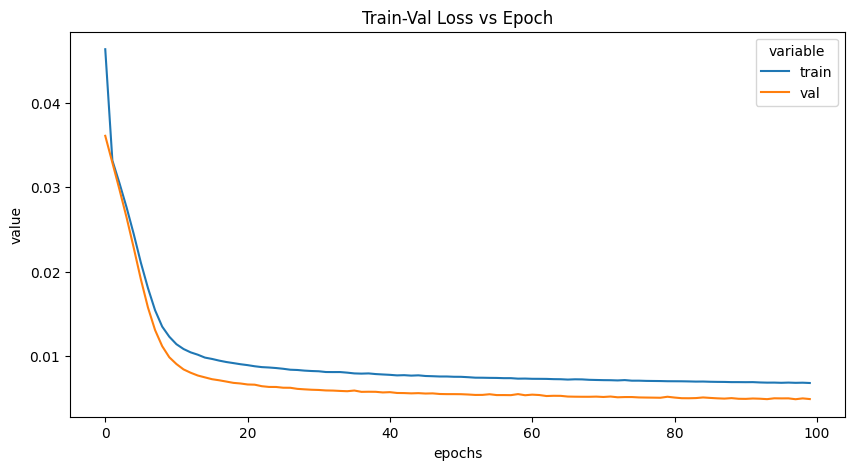

In [ ]:
plt.figure(figsize = (10, 5))

sns.lineplot(data = train_val_loss_df,
             x = "epochs", y = "value",
             hue = "variable").set_title("Train-Val Loss vs Epoch")

In [ ]:
# lets compute R-square score of the model on the validation data.(just cause)

y_true = []
y_pred = []

with torch.no_grad(): # torch. no_grad() disables computing gradients, helps with running the calculation. Remember for now.

  model.eval()
  for x_batch, y_batch in val_dl:
    x_batch = x_batch.to(device)

    y_test_pred = model(x_batch)
    y_true.extend(y_batch) # contain the real data / true answer
    y_pred.extend(y_test_pred) # preds

    y_true_stacked = torch.stack((y_true))

    y_true_stacked[:10] #stacks a bunch of vectors/tensors into a list of single ones

    y_pred_stacked = torch.stack((y_pred))

    y_pred_stacked[:10] #stacks a bunch of vectors/tensors into a list of single ones

    MSE = MeanSquaredError().to(device)
    r2score = R2Score().to(device)

    print("MSE: ", round(MSE(y_pred_stacked.to(device), y_true_stacked.to(device)).item(), 3))
    print("R Squared: ", round(r2score(y_pred_stacked.to(device), y_true_stacked.to(device)).item(), 3))

MSE:  0.001
R Squared:  0.938
MSE:  0.008
R Squared:  0.738
MSE:  0.007
R Squared:  0.9
MSE:  0.008
R Squared:  0.86
MSE:  0.006
R Squared:  0.866
MSE:  0.006
R Squared:  0.867
MSE:  0.006
R Squared:  0.845
MSE:  0.006
R Squared:  0.863
MSE:  0.006
R Squared:  0.844
MSE:  0.006
R Squared:  0.835
MSE:  0.006
R Squared:  0.834
MSE:  0.007
R Squared:  0.823
MSE:  0.007
R Squared:  0.826
MSE:  0.007
R Squared:  0.818
MSE:  0.007
R Squared:  0.824
MSE:  0.007
R Squared:  0.838
MSE:  0.007
R Squared:  0.84
MSE:  0.007
R Squared:  0.839
MSE:  0.006
R Squared:  0.844
MSE:  0.006
R Squared:  0.849
MSE:  0.006
R Squared:  0.858
MSE:  0.006
R Squared:  0.858
MSE:  0.006
R Squared:  0.86
MSE:  0.006
R Squared:  0.86
MSE:  0.005
R Squared:  0.862
MSE:  0.005
R Squared:  0.875
MSE:  0.005
R Squared:  0.88
MSE:  0.005
R Squared:  0.879
MSE:  0.005
R Squared:  0.878
MSE:  0.005
R Squared:  0.881
MSE:  0.005
R Squared:  0.881
MSE:  0.005
R Squared:  0.877
MSE:  0.005
R Squared:  0.884
MSE:  0.005
R Squ